# CS 579
<br>

## Clustering Words with K-Means

<br>


# Motivation

Often, we want to know which features appear together.

- If you liked *Twilight* you might like *Nosferatu*.
- "happy" is a synonym of "glad."

Can be used to summarize a large collection of messages.

We'll use k-means to cluster together related words from Twitter.

**Caution:** This uses live Twitter data, which often contains profanity.

In [1]:
# Get some tweets containing the word 'i'.

import os
from TwitterAPI import TwitterAPI

# Read Twitter credentials from environmental variables.
api = TwitterAPI(os.environ.get('TW_CONSUMER_KEY'),
                 os.environ.get('TW_CONSUMER_SECRET'),
                 os.environ.get('TW_ACCESS_TOKEN'),
                 os.environ.get('TW_ACCESS_TOKEN_SECRET'))

# Collect 10000 tweets.
tweets = []
while True: 
    r = api.request('statuses/filter', {'track':'i',
                                        'language':'en'})
    if r.status_code != 200: # error
        break
    else:
        for item in r.get_iterator():
            tweets.append(item)
            if len(tweets) > 10000:
                break
            elif len(tweets) % 100 == 0:
                print(len(tweets))


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000


In [2]:
print(len(tweets))

10006


In [3]:
# Each tweet is a Python dict.
print('text', tweets[0]['text'])
print('description:', tweets[0]['user']['description'])
print('name:', tweets[0]['user']['name'])
print('location:', tweets[0]['user']['location'])

text RT @theMasonRamsey: Yes I am the real Mason Ramsey https://t.co/VU6CYSaN6c
description: None
name: 🇲🇽🖤
location: Alief,TX


In [4]:
tweets = [t for t in tweets if 'text' in t]

In [5]:
len(tweets)

9238

In [6]:
# Tokenize each tweet text.
import re
tokens = []
for tweet in tweets:
    text = tweet['text'].lower()
    text = re.sub('@\S+', ' ', text)  # Remove mentions.
    text = re.sub('http\S+', ' ', text)  # Remove urls.
    tokens.append(re.findall('[A-Za-z]+', text)) # Retain words.
tokens[0]

['rt', 'yes', 'i', 'am', 'the', 'real', 'mason', 'ramsey']

In [7]:
# Count words.
from collections import Counter

word_counts = Counter()
for tweet in tokens:
    word_counts.update(tweet)

In [8]:
# Inspect word counts.
import math

print(len(word_counts), 'unique terms')
word_counts.most_common(10)

12763 unique terms


[('i', 10975),
 ('rt', 4808),
 ('the', 3709),
 ('to', 3538),
 ('a', 3049),
 ('you', 2375),
 ('and', 2342),
 ('my', 1919),
 ('m', 1843),
 ('t', 1587)]

In [9]:
# Retain in vocabulary words occurring more than twice.
vocab = set([w for w, c in word_counts.items() if c > 2])
print('%d words occur at least three times.' % len(vocab))

3957 words occur at least three times.


In [10]:
# Prune tokens.
newtoks = []
for i, tweet in enumerate(tokens):
    newtok = [token for token in tweet if token in vocab]
    if len(newtok) > 0:
        newtoks.append(newtok)
tokens = newtoks

In [11]:
# A sample pruned tweet.
tokens[0]

['rt', 'yes', 'i', 'am', 'the', 'real', 'mason', 'ramsey']

In [35]:
tokens[2]

['yourself',
 'a',
 'common',
 'interview',
 'question',
 'i',
 'find',
 'that',
 'to',
 'be',
 'the',
 'first',
 'ice',
 'this',
 'is',
 'the',
 'chance',
 'to']

**Context features**

To determine if two words are similar, we will create a feature vector that counts how often other words appear nearby.

E.g.,

> I really **love** school.

> I really **like** school.

> You **love** school.

**love:** {really@-1: 1, school@1: 1, you@-1: 1}

**like:** {really@-1: 1, school@1: 1}

<br>

**Assumption**: words with similar meaning have similar contexts vectors.



In [12]:
import numpy as np
def get_contexts(tweet, i, window):
    """
    Get the context features for token at position i
    in this tweet, using the given window size.
    """
    features = []
    for j in range(np.amax([0, i-window]), i):
        features.append(tweet[j] + "@" + str(j-i))
    for j in range(i+1, min(i + window + 1, len(tweet))):
        features.append(tweet[j] + "@" + str(j-i))
    return features

print('context for word %s in %s' % (tokens[0][3], tokens[0]))
print(get_contexts(tokens[0], i=3, window=2))

context for word am in ['rt', 'yes', 'i', 'am', 'the', 'real', 'mason', 'ramsey']
['yes@-2', 'i@-1', 'the@1', 'real@2']


** Q: How would the approach differ if we ignore location of context?**

E.g., **love:** {really: 1, school:1, you: 1} **vs** {really@-1: 1, school@1: 1, you@-1: 1}

In [13]:
# For each term, create a context vector, indicating how often
# each word occurs to the left or right of it.
from collections import defaultdict
import numpy as np

# dict from term to context vector.
contexts = defaultdict(lambda: Counter())
window = 2
for tweet in tokens:
    for i, token in enumerate(tweet):
        features = get_contexts(tweet, i, window)
        contexts[token].update(features)
        # Optionally: ignore word order
        # contexts[token].update(tweet[:i] + tweet[i+1:])


In [14]:
contexts['i'].most_common(20)

[('m@1', 1790),
 ('rt@-1', 1612),
 ('t@2', 761),
 ('a@2', 551),
 ('to@2', 473),
 ('rt@-2', 438),
 ('and@-1', 410),
 ('love@1', 406),
 ('can@1', 383),
 ('ve@1', 361),
 ('you@2', 345),
 ('have@1', 341),
 ('just@1', 328),
 ('don@1', 313),
 ('was@1', 305),
 ('am@1', 301),
 ('the@2', 281),
 ('but@-1', 274),
 ('when@-1', 257),
 ('the@-2', 256)]

**tf-idf vectors**

- We will transform the context features by dividing by (the log of) the number of distinct terms this feature appears in.

In [15]:
# Compute the number of different contexts each term appears in.
# Actually: this is the total number of times this context feature appears.
tweet_freq = Counter()
for context in contexts.values():
    tweet_freq.update(context)
tweet_freq.most_common(5)

[('i@-1', 10854),
 ('i@-2', 10507),
 ('i@1', 9005),
 ('i@2', 6890),
 ('rt@-1', 4779)]

In [16]:
Counter(tweet_freq.values())

Counter({1: 256,
         2: 778,
         3: 3419,
         4: 2030,
         5: 1316,
         6: 946,
         7: 751,
         8: 602,
         9: 446,
         10: 398,
         11: 330,
         12: 281,
         13: 273,
         14: 249,
         15: 158,
         16: 161,
         17: 127,
         18: 114,
         19: 126,
         20: 128,
         21: 117,
         22: 96,
         23: 95,
         24: 86,
         25: 77,
         26: 62,
         27: 57,
         28: 60,
         29: 59,
         30: 55,
         31: 63,
         32: 49,
         33: 57,
         34: 53,
         35: 40,
         36: 22,
         37: 34,
         38: 36,
         39: 36,
         40: 17,
         41: 26,
         42: 23,
         43: 39,
         44: 25,
         45: 20,
         46: 23,
         47: 28,
         48: 35,
         49: 29,
         50: 18,
         51: 23,
         52: 23,
         53: 19,
         54: 15,
         55: 14,
         56: 19,
         57: 17,
         58: 27,

In [36]:
# As opposed to the above, this computes the number of unique terms that this feature
# appears in. Q: How do you expect to affect the output?
tweet_freq_2 = Counter()
for context in contexts.values():
    tweet_freq_2.update(context.keys())
tweet_freq_2.most_common(5)

[('i@2', 1330),
 ('i@1', 1288),
 ('i@-2', 1256),
 ('the@-1', 1096),
 ('and@1', 933)]

In [17]:
# Transform each context vector to be term freq / tweet frequency. 
# Also then normalize by length.
for term, context in contexts.items():
    for term2, frequency in context.items():
        # tf / [ 1 + log(df) ]
        context[term2] = frequency / (1. + math.log(tweet_freq[term2]))
    length = math.sqrt(sum([v*v for v in context.values()]))
    for term2, frequency in context.items():
        context[term2] = 1. * frequency / length
    
contexts['i'].most_common(5)

[('m@1', 0.5511605454669377),
 ('rt@-1', 0.44642171936297137),
 ('t@2', 0.23899707634438072),
 ('a@2', 0.16079304530543112),
 ('love@1', 0.14318770023761604)]

In [18]:
contexts['school'].most_common(10)

[('high@-1', 0.33410017477798243),
 ('middle@-1', 0.31465991108735275),
 ('at@-1', 0.26749252152079955),
 ('of@-1', 0.23182846238255211),
 ('sick@-2', 0.2246190640179431),
 ('i@2', 0.19616667753883338),
 ('in@-2', 0.1763260756319353),
 ('shit@2', 0.15553285234615388),
 ('graduating@-2', 0.14247533632849224),
 ('and@1', 0.13792546407585593)]

In [19]:
contexts['love'].most_common(10)

[('i@-1', 0.8547243969778506),
 ('you@1', 0.29242881848427854),
 ('rt@-2', 0.1944978477641765),
 ('i@-2', 0.10559498057118918),
 ('so@2', 0.09870444112740873),
 ('this@1', 0.08385902973871077),
 ('him@1', 0.07599052784866119),
 ('in@-1', 0.07280605299458265),
 ('the@1', 0.07064898763556308),
 ('to@1', 0.06617376598304402)]

In [20]:
contexts['hate'].most_common(10)

[('i@-1', 0.7461742331051283),
 ('rt@-2', 0.3454380166083687),
 ('broke@2', 0.21714974804128767),
 ('i@-2', 0.1594107231050546),
 ('my@1', 0.14994363863091223),
 ('ikea@1', 0.14483056224152382),
 ('when@1', 0.13738893905677277),
 ('fucking@-1', 0.1168426840411504),
 ('you@1', 0.10572992887476061),
 ('asshole@1', 0.09655370816101587)]

At this point we have a list of dictionaries, one per term, indicating the terms that co-occur (weighted by inverse tweet frequency).

Next, we have to cluster these vectors. To do this, we'll need to be able to compute the euclidean distance between two vectors.

In [21]:
# n.b. This is not efficient!
def distance(c1, c2):
    if len(c1.keys()) == 0 or len(c2.keys()) == 0:
        return 1e9
    keys = set(c1.keys()) | set(c2.keys())
    distance = 0.
    for k in keys:
        distance += (c1[k] - c2[k]) ** 2
    return math.sqrt(distance)

print(distance({'hi':10, 'bye': 5}, {'hi': 9, 'bye': 4}))
print(distance({'hi':10, 'bye': 5}, {'hi': 8, 'bye': 4}))

1.4142135623730951
2.23606797749979


In [22]:
def find_closest(term, n=5):
    terms = np.array(list(contexts.keys()))
    context = contexts[term]
    distances = []
    for term2, context2 in contexts.items():
        distances.append(distance(context, context2))
    return terms[np.argsort(distances)][:n]

find_closest('love', n=10)

array(['love', 'm', 'hope', 'am', 'hate', 'guess', 'll', 'think', 'saw',
       'swear'],
      dtype='<U31')

In [23]:
nz_contexts = [t for t, context in contexts.items()
               if len(context) > 1]
contexts = dict([(term, contexts[term]) for term in nz_contexts])
print(len(nz_contexts), 'nonzero contexts')

3957 nonzero contexts


In [24]:
# e.g., what are three context features for the term "rt"?
print(list(contexts.keys())[0])
print(list(list(contexts.values())[0].items())[:3])

rt
[('yes@1', 0.018047454989163745), ('i@2', 0.24309157328634765), ('i@1', 0.8709649191368568)]


In [25]:
# Transform context dicts to a sparse vector
# for sklearn.
from sklearn.feature_extraction import DictVectorizer

vec = DictVectorizer()
X = vec.fit_transform(contexts.values())
names = np.array(vec.get_feature_names())
print(names[:10])
print(X[0])

['a@-1' 'a@-2' 'a@1' 'a@2' 'aaron@-1' 'aaron@-2' 'aaron@1' 'aaron@2'
 'ab@-1' 'ab@-2']
  (0, 0)	0.000608391440993
  (0, 1)	0.00184155775432
  (0, 2)	0.0296784604665
  (0, 3)	0.023081968924
  (0, 24)	0.000772453342136
  (0, 36)	0.00142439996922
  (0, 85)	0.0024285643445
  (0, 113)	0.00127100472844
  (0, 120)	0.00177305816505
  (0, 137)	0.00150039652435
  (0, 145)	0.00102174921021
  (0, 152)	0.00260173305892
  (0, 156)	0.00144728974486
  (0, 161)	0.00140347229238
  (0, 185)	0.00826629566769
  (0, 201)	0.00457615712315
  (0, 208)	0.0113951997537
  (0, 216)	0.00260173305892
  (0, 241)	0.00140347229238
  (0, 251)	0.00686423568472
  (0, 264)	0.00209241574335
  (0, 265)	0.00228807856157
  (0, 270)	0.00844293530641
  (0, 271)	0.00381327693678
  (0, 279)	0.000975855587642
  :	:
  (0, 15466)	0.0136718731665
  (0, 15467)	0.00928134083236
  (0, 15486)	0.0180474549892
  (0, 15487)	0.00231672663195
  (0, 15490)	0.00381301418531
  (0, 15506)	0.0024285643445
  (0, 15511)	0.00177305816505
  (0, 15514)	

In [37]:
# Which row of X is the word "love"?
love_idx = list(contexts.keys()).index('love')
print(love_idx)
# What are the context feature values for love?
print(X[love_idx])
# Print a highly ranking feature.
print(names[15534])

182
  (0, 0)	0.00724304929286
  (0, 1)	0.00243602184957
  (0, 2)	0.0144216061026
  (0, 3)	0.00723148684548
  (0, 5)	0.0103247566851
  (0, 6)	0.00830357417341
  (0, 34)	0.0292170548963
  (0, 145)	0.00405472496588
  (0, 168)	0.00830357417341
  (0, 195)	0.00908004545032
  (0, 224)	0.00677702198663
  (0, 245)	0.0103247566851
  (0, 271)	0.00756633283537
  (0, 279)	0.00387260002237
  (0, 347)	0.00397254888256
  (0, 394)	0.00581154099097
  (0, 395)	0.0058612011343
  (0, 396)	0.0115587334938
  (0, 397)	0.0145227471674
  (0, 437)	0.00442936574452
  (0, 450)	0.00355215339765
  (0, 451)	0.00716303370885
  (0, 455)	0.00312683202546
  (0, 457)	0.00315557592013
  (0, 472)	0.00735516704871
  :	:
  (0, 15339)	0.00659377767189
  (0, 15347)	0.0173724037235
  (0, 15385)	0.00656081846393
  (0, 15405)	0.00908004545032
  (0, 15413)	0.00496134498333
  (0, 15427)	0.00908004545032
  (0, 15430)	0.011477652128
  (0, 15434)	0.008896229578
  (0, 15485)	0.00801508651213
  (0, 15487)	0.0045968664423
  (0, 15504)	0.0

In [27]:
# Let's cluster!
# http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans
num_clusters = 20
kmeans = KMeans(num_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [28]:
# Let's print out the top features for each mean vector.
# This is swamped by common terms
for i in range(num_clusters):
    print(i, ' '.join(names[np.argsort(
        kmeans.cluster_centers_[i])[::-1][:5]]))

0 on@-1 you@2 on@-2 i@-2 i@1
1 i@-2 m@-1 i@2 i@1 m@-2
2 and@1 the@-2 i@1 the@-1 a@-2
3 i@-1 i@-2 rt@-2 a@1 you@1
4 in@1 on@1 the@2 i@-2 my@2
5 i@1 i@-2 the@-1 a@-2 to@-2
6 the@-1 in@-2 i@2 i@1 on@-2
7 t@1 i@-1 you@-1 rt@-2 even@2
8 a@-1 the@-1 i@2 i@1 and@1
9 to@-1 i@-2 i@-1 a@1 the@1
10 this@-1 i@1 i@2 a@-1 the@-1
11 my@-1 i@1 i@2 of@-2 and@1
12 i@2 i@1 i@-2 but@1 to@-2
13 up@1 i@-2 i@-1 i@2 and@-1
14 rt@-1 i@2 i@1 s@1 is@1
15 i@1 rt@-1 m@2 i@2 the@-2
16 me@1 t@-1 i@-2 i@-1 to@-1
17 for@1 the@2 i@-2 a@-2 a@-1
18 of@1 the@-1 the@2 my@2 i@-2
19 to@1 i@-2 i@-1 the@2 be@2


In [29]:
# .transform will compute the distance from each context to each cluster.
distances = kmeans.transform(X)
# e.g., what is the distance from the word "love" to each cluster?
print('distance from term "love" to each cluster:')
print(distances[love_idx])
# what is the closest cluster for the word "love"?
print('closest cluster to "love":')
print(np.argmin(distances[love_idx]))

distance from term "love" to each cluster:
[ 1.02299852  0.98543462  0.99026422  0.5854914   0.98713006  0.97795726
  1.02537547  1.09786564  1.02773076  0.97479063  1.01424504  1.04027972
  0.98008083  0.98354497  1.00036492  1.03436615  0.91330911  1.00144954
  1.02748702  0.99320934]
closest cluster to "love":
3


In [30]:
# Finally, we'll print the words that are closest
# to the mean of each cluster.
terms = np.array(list(contexts.keys()))
for i in range(distances.shape[1]):
    print(i, ' '.join(terms[np.argsort(distances[:,i])[1:10]]), '\n')

0 soundcloud tv friday itunes tour holiday earth bbc repeat 

1 sorry glad getting crying joking a gonna shaking done 

2 day and person one time girlfriend that of ins 

3 love am just ll guess think hope hate have 

4 participate lookin sacked stuck working back involved debate born 

5 that the this but like for on me a 

6 world gym streets uk best area worst most first 

7 didn wasn wouldn ain haven couldn won doesn shouldn 

8 few great bit good little playlist blessing problem job 

9 see say win get do go make watch sleep 

10 is morning tweet thread faithfulness year month shit guy 

11 heart favorite phone mom brain homie spotify mind boyfriend 

12 how the and this gray so baffled every easier 

13 woke fucked messed shut growing wrapped pulled heads picking 

14 gray dear i hi tracklist if goodnight awww this 

15 but when omg and yeah yes if hello because 

16 follow get ask make see help leave do told 

17 thankful thanks apologize plans pay looking bloom voted praying 



Clearly, interpreting these results requires a bit of investigation.

As the number of tweets increases, we expect these clusters to become more coherent.

**How does error decrease with number of cluster?**

In [31]:
kmeans.score(X)

-3610.7138169426016

k=5 score=3745.59
k=10 score=3673.62
k=20 score=3619.19
k=50 score=3533.6
k=100 score=3456.81


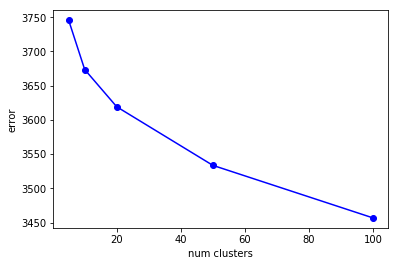

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

scores = []
num_cluster_options = [5,10,20,50,100]

for num_clusters in num_cluster_options:
    kmeans = KMeans(num_clusters, n_init=10, max_iter=10)
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('k=%d score=%g' % (num_clusters, score))
    
plt.figure()
plt.plot(num_cluster_options, scores, 'bo-')
plt.xlabel('num clusters')
plt.ylabel('error')
plt.show()

** How does error vary by initalization? **

score=3621.13
score=3614.67
score=3628.88
score=3633.02
score=3628.3
score=3629.97
score=3633.27
score=3640.09
score=3637.93
score=3635.66


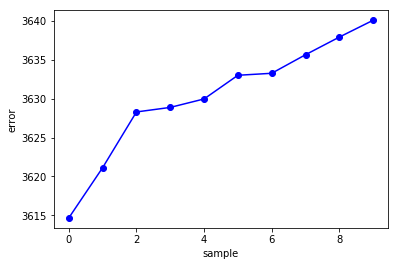

In [33]:
scores = []
for i in range(10):
    kmeans = KMeans(20, n_init=1,
                    max_iter=100,
                    init='random')
    kmeans.fit(X)
    score = -1 * kmeans.score(X)
    scores.append(score)
    print('score=%g' % (score))
     
    
plt.figure()
plt.plot(range(10), sorted(scores), 'bo-')
plt.xlabel('sample')
plt.ylabel('error')
plt.show()